# Conversion From a LIF network to DynapSim Network

In [1]:
# - Rockpool imports
from rockpool import TSEvent, TSContinuous
from rockpool.nn.modules import LIFJax, LinearJax, ExpSynJax
from rockpool.nn.modules.jax.jax_lif_ode import LIFODEJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# - Numpy
import numpy as np
import seaborn as sns
from rockpool.devices.dynapse import (
    mapper,
    autoencoder_quantization,
    config_from_specification,
    dynapsim_from_graph,
    dynapsim_from_config,
)

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# - Network size
Nin = 12
N1 = 20
N2 = 8
N3 = 4
input_scale = 20.
dt = 1e-3

In [3]:
# - Generate a network using the sequential combinator
modFFwd = Sequential(
    LinearJax((Nin, N1), has_bias = False), # 30x20
    LIFODEJax((N1, N1), dt = dt, has_rec=True), # 40x40
    LinearJax((N1, N2), has_bias = False), # 30x20
    LIFODEJax((N2, N2), dt = dt, has_rec=True), # 40x40
    LinearJax((N2, N3), has_bias = False), # 30x20
    LIFODEJax((N3, N3), dt = dt, has_rec=True), # 40x40
)

print(modFFwd)

JaxSequential  with shape (12, 4) {
    LinearJax '0_LinearJax' with shape (12, 20)
    LIFODEJax '1_LIFODEJax' with shape (20, 20)
    LinearJax '2_LinearJax' with shape (20, 8)
    LIFODEJax '3_LIFODEJax' with shape (8, 8)
    LinearJax '4_LinearJax' with shape (8, 4)
    LIFODEJax '5_LIFODEJax' with shape (4, 4)
}


In [4]:
from rockpool.devices.dynapse import DynapseNeurons

In [5]:
from rockpool.graph.utils import bag_graph, find_recurrent_modules

mod_graph = modFFwd.as_graph()
modules, rec_modules = find_recurrent_modules(mod_graph)

In [6]:
modules

[LinearWeights "LinearJax_'0_LinearJax'_4374542464" with 12 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_4368815808" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_4368815808" with 20 input nodes -> 20 output nodes,
 LinearWeights "LinearJax_'2_LinearJax'_5092799440" with 20 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11361365168" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11361365168" with 8 input nodes -> 8 output nodes,
 LinearWeights "LinearJax_'4_LinearJax'_11361359360" with 8 input nodes -> 4 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11361445936" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11361445936" with 4 input nodes -> 4 output nodes]

In [7]:
rec_modules

[LinearWeights "LIFODEJax_recurrent_'1_LIFODEJax'_4368815808" with 20 input nodes -> 20 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'1_LIFODEJax'_4368815808" with 20 input nodes -> 20 output nodes,
 LinearWeights "LIFODEJax_recurrent_'3_LIFODEJax'_11361365168" with 8 input nodes -> 8 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'3_LIFODEJax'_11361365168" with 8 input nodes -> 8 output nodes,
 LinearWeights "LIFODEJax_recurrent_'5_LIFODEJax'_11361445936" with 4 input nodes -> 4 output nodes,
 LIFNeuronWithSynsRealValue "LIFODEJax_'5_LIFODEJax'_11361445936" with 4 input nodes -> 4 output nodes]

In [8]:
mod_se2 = dynapsim_from_graph(modFFwd.as_graph())
mod_se2

JaxSequential  with shape (12, 32) {
    LinearJax '0_LinearJax' with shape (12, 32)
    DynapSim '1_DynapSim' with shape (32, 32)
}

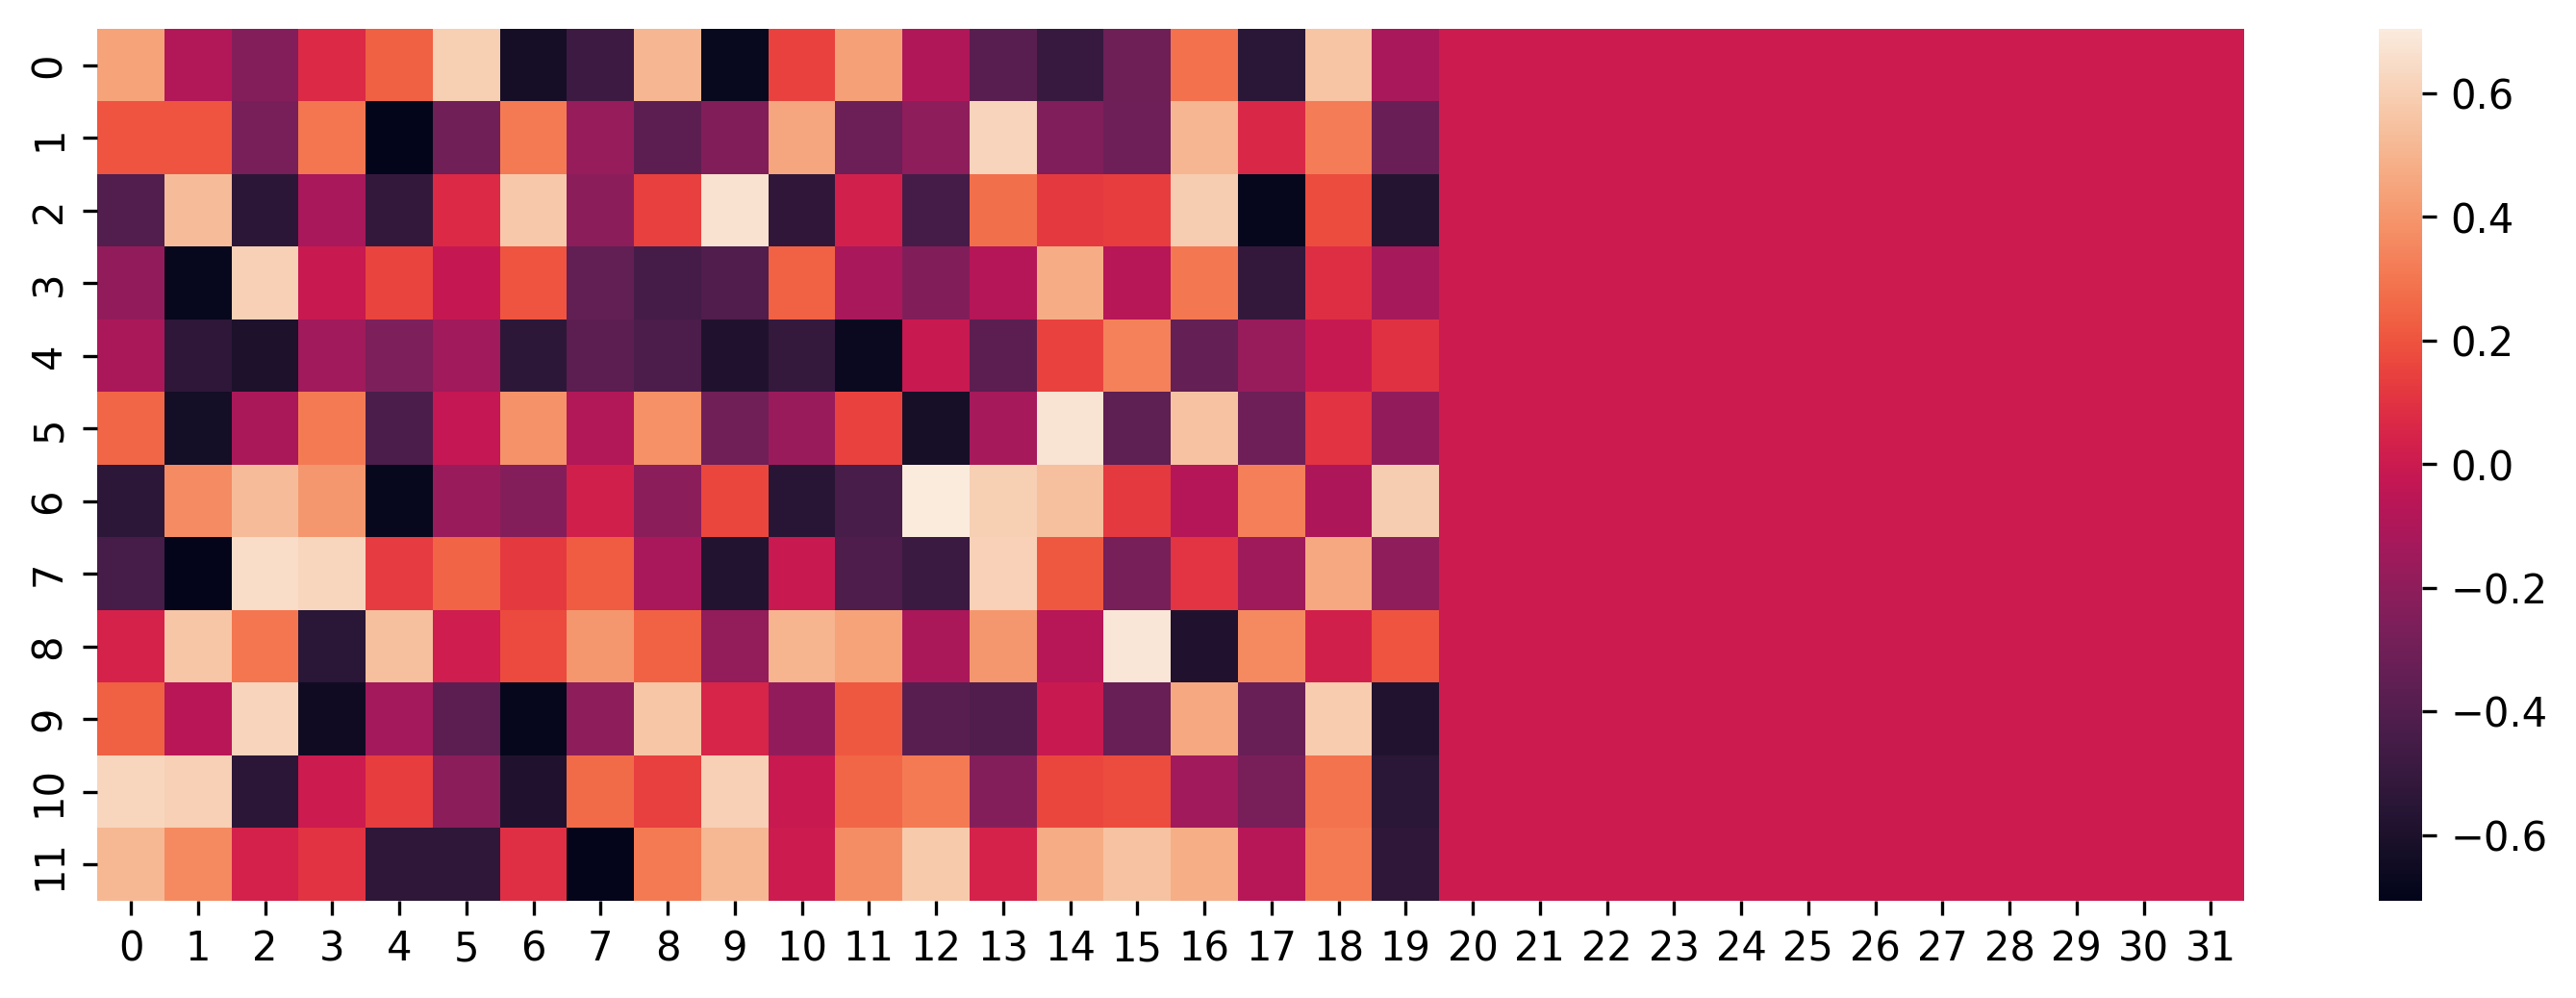

In [9]:
ax = sns.heatmap(mod_se2[0].weight)
plt.show()

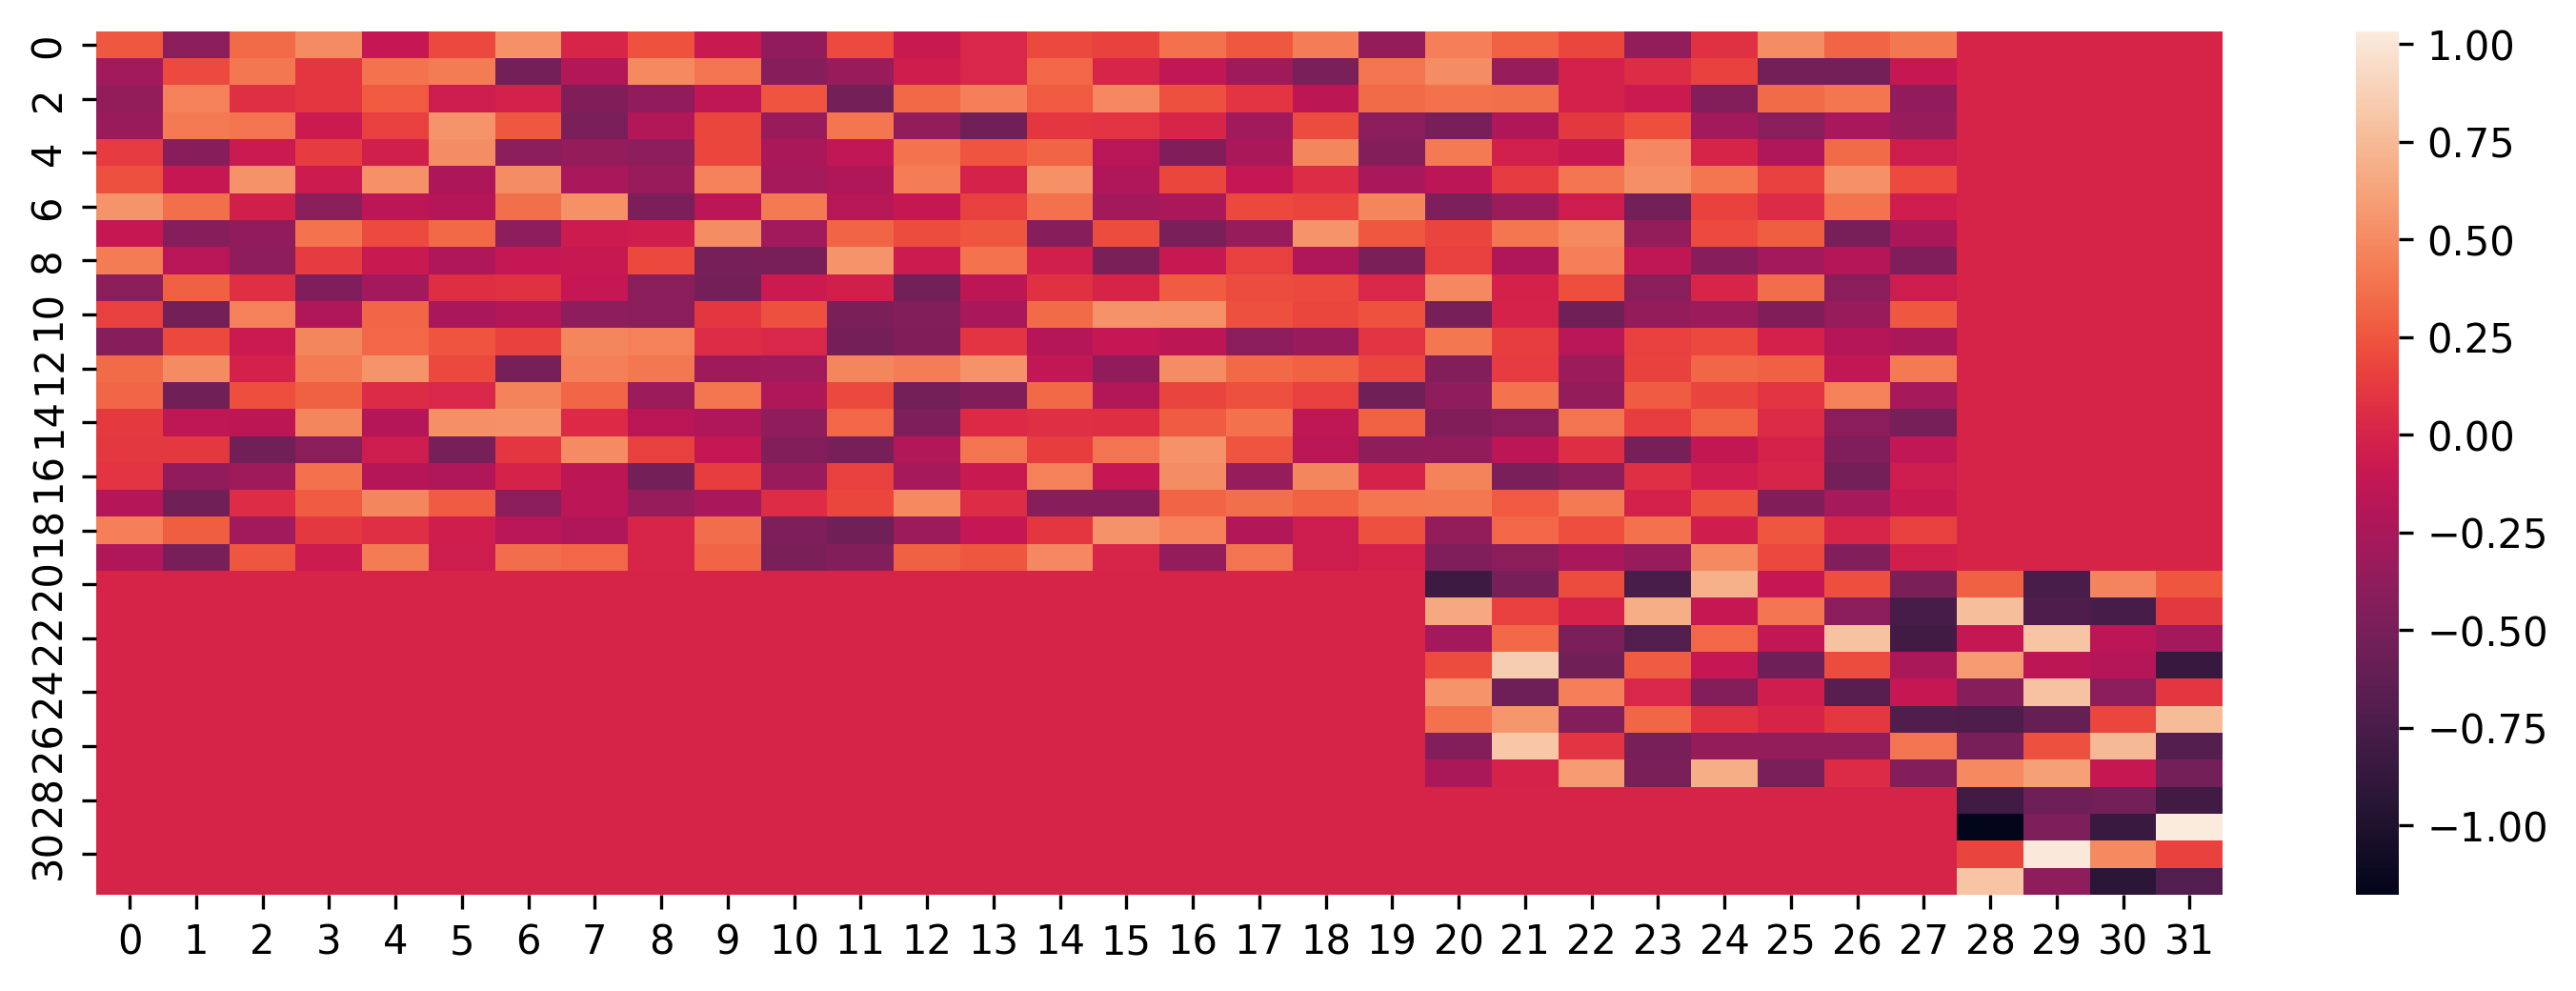

In [10]:
ax = sns.heatmap(mod_se2[1].w_rec)


In [11]:
spec = mapper(modFFwd.as_graph())
spec

{'mapped_graph': GraphHolder "JaxSequential__11361449200_transformed_SE_11572428512" with 12 input nodes -> 32 output nodes,
 'weights_in': array([[ 4.43034566e-01, -8.75299746e-02, -2.33493962e-01,
          6.96906403e-02,  2.30980147e-01,  5.94967946e-01,
         -6.26084561e-01, -4.79481915e-01,  5.08641661e-01,
         -6.77752339e-01,  1.48024914e-01,  4.29961191e-01,
         -9.31854453e-02, -3.75642676e-01, -4.97160740e-01,
         -3.11357049e-01,  2.81820670e-01, -5.49383283e-01,
          5.56565827e-01, -1.21213164e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 2.00706795e-01,  1.98584098e-01, -2.75024696e-01,
          2.98388912e-01, -7.06184733e-01, -2.98555102e-01,
          3.11727047e-01, -1.71921351e-01, -3.68271456e-01,
         -2.44150963e-01,  4.55369710

In [12]:
spec.update(autoencoder_quantization(**spec))
spec


{'mapped_graph': GraphHolder "JaxSequential__11361449200_transformed_SE_11572428512" with 12 input nodes -> 32 output nodes,
 'weights_in': [array([[ 7,  0,  4,  0,  6, 11, 15, 14, 13, 15,  2, 14,  8,  3, 11,  5,
          10, 15,  7,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 3,  8,  1, 12, 15,  5,  5,  8, 13,  8, 14,  5,  5, 15,  9,  2,
          15,  0, 13,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [14, 15,  7,  8, 14,  8,  7, 12,  2, 15, 14,  0, 14,  1,  4,  0,
          13, 15,  8, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 4, 15, 15,  0,  1,  0,  6,  9,  7,  3,  5,  2,  2,  0, 11,  0,
           6, 13,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 4,  7, 15,  8, 10,  1, 15, 10, 13, 14, 11, 15,  0, 14,  1,  5,
          10,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
         [ 1, 15,  4, 10, 11,  0,  9,  2,  9,  9,  4,  1, 15,  8, 15,  3,
           7,  3,  2,  4,  0,  0,  0,  0, 

In [13]:
config, input_channel_map = config_from_specification(**spec)

In [14]:
mod_se2_reconstructed = dynapsim_from_config(config)

In [15]:
from rockpool.devices.dynapse.quantization import WeightHandler

In [16]:
mod_se2_reconstructed[0].weight

array([[ 0.48490466,  0.        , -0.15260715,  0.        ,  0.31207103,
         0.47693374, -0.62954088, -0.45670725,  0.470077  , -0.62954088,
         0.15946388,  0.45670725, -0.14463623, -0.33229751, -0.47693374,
        -0.32544078,  0.30410011, -0.62954088,  0.48490466, -0.15260715,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.33229751,  0.14463623, -0.17283363,  0.29724337, -0.62954088,
        -0.32544078,  0.32544078, -0.14463623, -0.470077  , -0.14463623,
         0.45670725, -0.32544078, -0.32544078,  0.62954088, -0.31746986,
        -0.15946388,  0.62954088,  0.        ,  0.470077  , -0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.45670725,  0.62954088, -0.48490466, -0.1446

In [17]:
int_mask = np.array(spec["weights_in"])
sign_mask = np.array(spec["sign_in"])
Iw = np.array([spec["Iw_0"], spec["Iw_1"], spec["Iw_2"], spec["Iw_3"]]).T
w_in_q = WeightHandler.restore_weight_matrix(n_bits=4, code=Iw, int_mask=int_mask, sign_mask=sign_mask) / mod_se2_reconstructed[1].Iscale

In [18]:
mod_se2_reconstructed[0].weight

array([[ 0.48490466,  0.        , -0.15260715,  0.        ,  0.31207103,
         0.47693374, -0.62954088, -0.45670725,  0.470077  , -0.62954088,
         0.15946388,  0.45670725, -0.14463623, -0.33229751, -0.47693374,
        -0.32544078,  0.30410011, -0.62954088,  0.48490466, -0.15260715,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.33229751,  0.14463623, -0.17283363,  0.29724337, -0.62954088,
        -0.32544078,  0.32544078, -0.14463623, -0.470077  , -0.14463623,
         0.45670725, -0.32544078, -0.32544078,  0.62954088, -0.31746986,
        -0.15946388,  0.62954088,  0.        ,  0.470077  , -0.31207103,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.45670725,  0.62954088, -0.48490466, -0.1446

In [19]:
w_in_q[0]

array([[ 0.48557335, -0.        , -0.1516691 ,  0.        ,  0.31250793,
         0.48016658, -0.63183564, -0.45877028,  0.47099686, -0.63183564,
         0.16083883,  0.45877028, -0.14626232, -0.3339043 , -0.48016658,
        -0.32473454,  0.30710116, -0.63183564,  0.48557335, -0.1516691 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.3339043 ,  0.14626232, -0.17306547,  0.2979314 , -0.63183564,
        -0.32473454,  0.32473454, -0.14626232, -0.47099686, -0.14626232,
         0.45877028, -0.32473454, -0.32473454,  0.63183564, -0.31932777,
        -0.16083883,  0.63183564,  0.        ,  0.47099686, -0.31250793,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-0.45877028,  0.63183564, -0.48557335, -0.1462

### Values are close but not exactly the same!!!

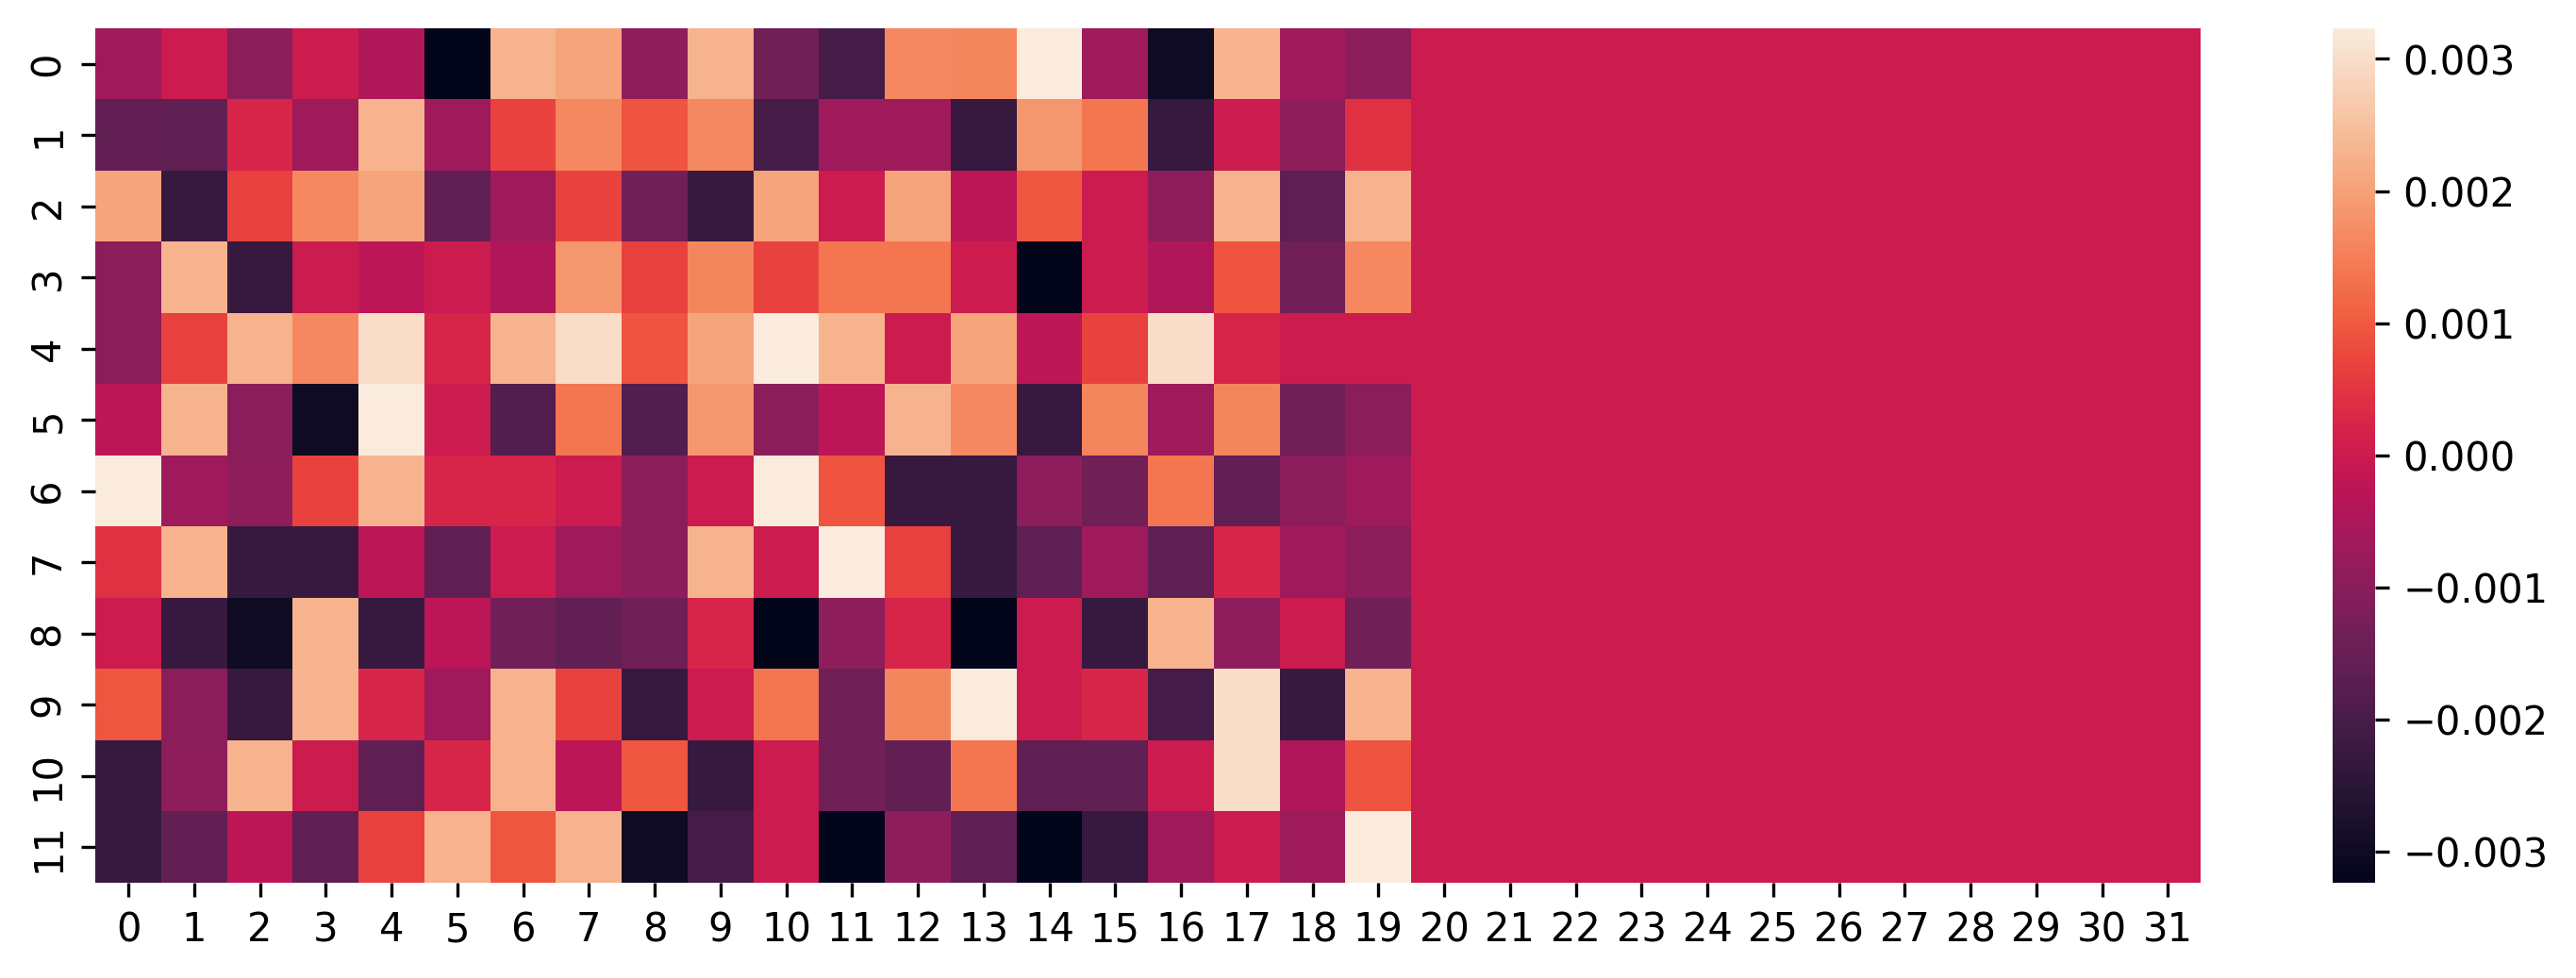

In [20]:
ax = sns.heatmap(mod_se2_reconstructed[0].weight - w_in_q[0])
plt.show()